# What is the most optimal skill to learn for Data Scientist?

Combine demand and salary signals to identify skills that are both common and well-paid in Data Scientist postings.

## Import Libraries and Data

In [61]:
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from adjustText import adjust_text

df = pd.read_csv('E:/Projects/Python_Data_Project/job_postings_flat_cleaned.csv')

## Data Cleanup

Filter to Data Scientist postings with salary, keep only non-empty skill lists, and explode skills to one row per skill mention.

In [62]:
df["job_skills"] = df["job_skills"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

df_DS = df[df["job_title_short"] == "Data Scientist"].copy()
df_DS = df_DS.dropna(subset=["salary_year_avg"])

mask_skills = df_DS["job_skills"].apply(lambda x: isinstance(x, list) and len(x) > 0)

print(f"DS postings with salary: {len(df_DS):,}")
print(
    f"DS postings with salary + skills: {mask_skills.sum():,} "
    f"({(1 - mask_skills.mean())*100:.1f}% missing/empty job_skills)"
)

df_DS = df_DS[mask_skills].copy()

df_DS_exploded = df_DS.explode("job_skills")


DS postings with salary: 16,547
DS postings with salary + skills: 13,542 (18.2% missing/empty job_skills)


## Calculate Percent of Job Postings that Have Skills

Build a skill-level table with counts, median salary, and skill share (%) among Data Scientist postings with salary and captured skills.

In [63]:
df_DS_skills = (
    df_DS_exploded.groupby("job_skills")["salary_year_avg"]
    .agg(skill_count="count", median_salary="median")
    .reset_index()
    .sort_values("skill_count", ascending=False)
)

DS_job_count = len(df_DS)
df_DS_skills["skill_percent"] = df_DS_skills["skill_count"] / DS_job_count * 100
df_DS_skills

,job_skills,skill_count,median_salary,skill_percent
134,python,10717,135000.0,79.138975
168,sql,7790,135000.0,57.524738
138,r,5752,132556.0,42.475262
178,tableau,2858,125000.0,21.104711
13,aws,2632,140000.0,19.435829
...,...,...,...,...
112,nuix,1,52400.0,0.007384
151,sass,1,80000.0,0.007384
183,tidyr,1,100000.0,0.007384
201,wire,1,100000.0,0.007384


## Median Salary vs Percent Skill Demand

- Here, skill_percent is the share of Data Scientist postings with salary and captured skills that mention a given skill.

- skill_limit = 5 means we keep skills appearing in more than 5% of that subset.

In [64]:
skill_limit = 5

df_DS_skills_high_demand = df_DS_skills[df_DS_skills['skill_percent'] > skill_limit]

## Coloring by Technology

- Map skills into broader technology groups and color the demand vs salary plot by technology category.

- Some skills can appear in more than one technology bucket in the source data. To avoid duplicated points after merging, each skill is assigned to a single technology using a fixed priority order (deterministic mapping).

In [65]:
df_technology = df['job_type_skills'].copy()

df_technology = df_technology.drop_duplicates()

df_technology = df_technology.dropna()

technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)
    for key, value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value
        else:
            technology_dict[key] = value

for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict

{'analyst_tools': ['alteryx',
  'sap',
  'looker',
  'tableau',
  'ms access',
  'visio',
  'excel',
  'datarobot',
  'spreadsheet',
  'cognos',
  'spss',
  'splunk',
  'esquisse',
  'word',
  'power bi',
  'powerbi',
  'qlik',
  'microstrategy',
  'msaccess',
  'ssrs',
  'powerpoint',
  'sheets',
  'sas',
  'dax',
  'nuix',
  'outlook',
  'sharepoint',
  'ssis'],
 'async': ['monday.com',
  'airtable',
  'smartsheet',
  'swit',
  'dingtalk',
  'workzone',
  'wimi',
  'clickup',
  'asana',
  'microsoft lists',
  'wrike',
  'jira',
  'trello',
  'workfront',
  'notion',
  'planner',
  'confluence'],
 'cloud': ['ibm cloud',
  'colocation',
  'digitalocean',
  'redshift',
  'watson',
  'aurora',
  'oracle',
  'bigquery',
  'firebase',
  'gcp',
  'databricks',
  'linode',
  'azure',
  'aws',
  'vmware',
  'heroku',
  'ovh',
  'openstack',
  'snowflake'],
 'programming': ['ocaml',
  'rust',
  'c#',
  'apl',
  'cobol',
  'r',
  'sql',
  'javascript',
  'solidity',
  'lua',
  'matlab',
  'erla

In [66]:
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

tech_order = ["programming", "analyst_tools", "cloud", "libraries", "other"]
df_technology["technology"] = pd.Categorical(df_technology["technology"], categories=tech_order, ordered=True)

df_technology = (
    df_technology
    .sort_values("technology")
    .drop_duplicates(subset=["skills"], keep="first")
    .reset_index(drop=True)
)

df_technology

,technology,skills
0,programming,dart
1,programming,golang
2,programming,mongodb
3,programming,scala
4,programming,powershell
...,...,...
250,NaN,google chat
251,NaN,symphony
252,NaN,zoom
253,NaN,microsoft teams


In [67]:
df_DS_skills_tech = df_DS_skills.merge(
    df_technology,
    left_on="job_skills",
    right_on="skills",
    how="inner"
)
df_DS_skills_tech

,job_skills,skill_count,median_salary,skill_percent,technology,skills
0,python,10717,135000.0,79.138975,programming,python
1,sql,7790,135000.0,57.524738,programming,sql
2,r,5752,132556.0,42.475262,programming,r
3,tableau,2858,125000.0,21.104711,analyst_tools,tableau
4,aws,2632,140000.0,19.435829,cloud,aws
...,...,...,...,...,...,...
201,nuix,1,52400.0,0.007384,analyst_tools,nuix
202,sass,1,80000.0,0.007384,programming,sass
203,tidyr,1,100000.0,0.007384,libraries,tidyr
204,wire,1,100000.0,0.007384,NaN,wire


In [68]:
df_DS_skills_tech_high_demand = df_DS_skills_tech[df_DS_skills_tech['skill_percent'] > skill_limit]

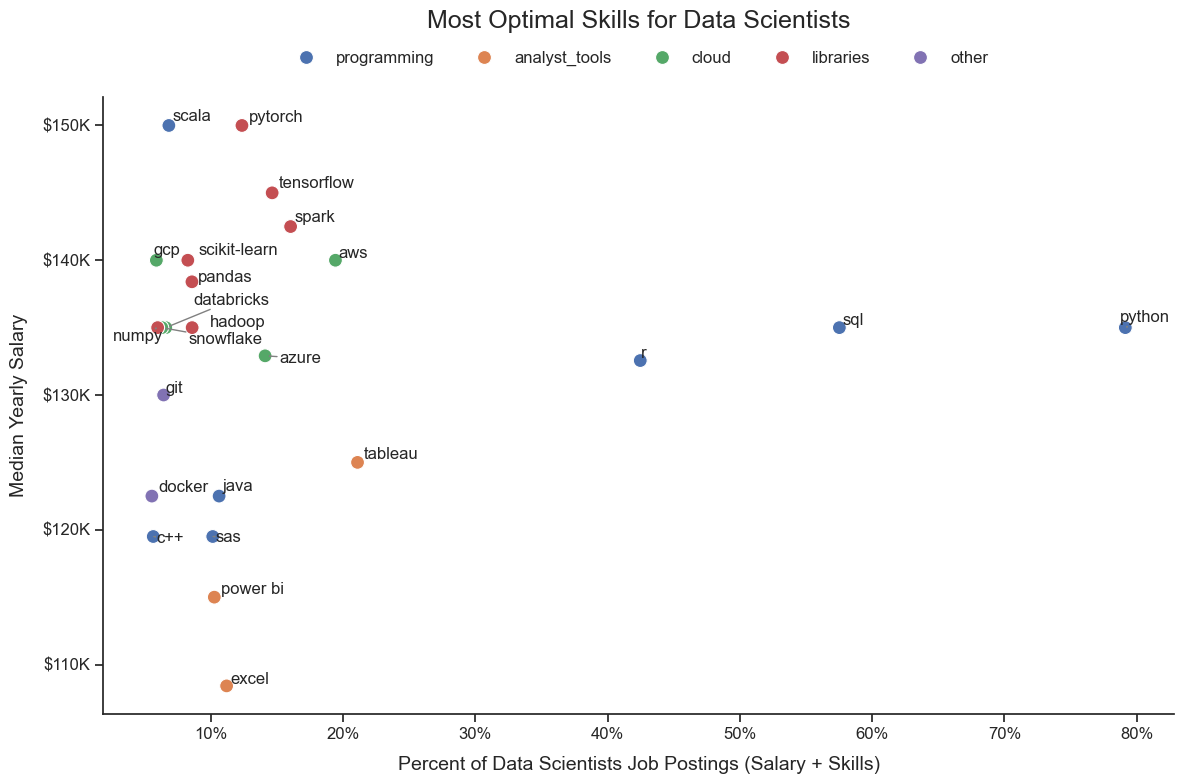

In [69]:
%%capture --no-display

sns.set_theme(style='ticks')
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_DS_skills_tech_high_demand,
    x='skill_percent',
    y='median_salary',
    hue='technology',
    s=100
)

sns.despine()

texts = []
for i, txt in enumerate(df_DS_skills_tech_high_demand["job_skills"]):
    texts.append(
        plt.text(
            df_DS_skills_tech_high_demand["skill_percent"].iloc[i],
            df_DS_skills_tech_high_demand["median_salary"].iloc[i],
            txt
        )
    )

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.xlabel('Percent of Data Scientists Job Postings (Salary + Skills)', fontsize=14, labelpad=10)
plt.ylabel('Median Yearly Salary', fontsize=14, labelpad=10)
plt.title('Most Optimal Skills for Data Scientists', fontsize=18, pad=50)

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.10),
    ncol=5,
    frameon=False,
    fontsize=12
)

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()